In [1]:
import numpy as np
import brian2 as bb
from brian2 import ms, second, Hz, mV, pA, nS, pF
#from np.random import rand,binomial
from time import time, asctime
import warnings

import sys


from matplotlib import pyplot as plt

faster_run = True

if faster_run:
    bb.set_device('cpp_standalone', directory='PETH_standalone', build_on_run=False)

In [3]:
bb.start_scope()
if faster_run:
    bb.get_device().reinit()
    bb.get_device().activate(build_on_run=False, directory='PETH_standalone')



g_l = 10.*nS
C_m = 200*pF
v_r = -60.*mV
v_e = 0.*mV
v_i = -80.*mV
tau_m_exc = 20.*ms
tau_m_inh = 20.*ms
tau_inh = 10*ms
tau_fast_inh = 10*ms
tau_exc = 5.*ms
tau_stdp = 20.*ms
alpha = .2
g_min = 0*nS
g_max = 50*nS

eqs_exc = '''dv/dt = (g_l*(v_r-v)+Ie+Ii+I)/(C_m) : volt
            dge/dt = -ge/(tau_exc) : siemens
            dgi/dt = -gi/(tau_inh) : siemens
            Ie = ge*(v_e-v) : amp
            Ii = gi*(v_i-v) : amp
            I : amp '''
eqs_inh = '''dv/dt = (g_l*(v_r-v)+Ie+Ii+I)/(C_m) : volt
            dge/dt = -ge/(tau_exc) : siemens
            dgi/dt = -gi/(tau_inh) : siemens
            Ie = ge*(v_e-v) : amp
            Ii = gi*(v_i-v) : amp
            I : amp '''
eq_stdp = '''dapost/dt = -apost/tau_stdp : 1 (event-driven)
            dapre/dt = -apre/tau_stdp : 1 (event-driven)
            w: siemens '''
eq_pre = '''gi+=w
            w=clip(w+eta_p*(apost-alpha)*g_ei,g_min,g_max)
            apre+=1'''
eq_post = '''w=clip(w+eta_p*apre*g_ei,g_min,g_max)
            apost+=1'''


Ne=1000
Ni=1000
cp_ee=.02
cp_ie=.02
cp_ei=.02
cp_ii=.02
pr=.05
pf=.05
g_ee=0.4*nS
g_ie=0.4*nS
g_ei=0.4*nS
g_ii=0.4*nS

cf_ffn=1.
cf_rec=1.

ext_input=150*pA

s_timestep = .1*ms       # simulation time step
D = 2*ms               # AP delay
m_ts = 1.*ms  

def if_else(condition, a, b) :
    if condition: return a
    else: return b


network=bb.Network()    
network.clock = bb.Clock(dt=s_timestep)    



# create a couple of groups
Pe = bb.NeuronGroup(Ne, eqs_exc, threshold='v>-50*mV',
                                    reset='v=-60*mV', refractory=2.*ms,method='euler')
Pi = bb.NeuronGroup(Ni, eqs_inh, threshold='v>-50*mV',
                                    reset='v=-60*mV', refractory=2.*ms,method='euler')
Pe.v = (-65 + 15*np.random.rand(Ne))*mV
Pi.v = (-65 + 15*np.random.rand(Ni))*mV

network.add(Pe,Pi)

N_p=1000
f_p=50*Hz
sp=.01
coef_ep=2.
P_poisson= bb.PoissonGroup(N_p,f_p,clock=network.clock)
network.add(P_poisson)

Cep= bb.Synapses(P_poisson,Pe,model='w:siemens',on_pre='ge+=w')
Cep.connect(p=sp)
Cep.w=coef_ep*g_ee
Cip= bb.Synapses(P_poisson,Pi,model='w:siemens',on_pre='ge+=w')
Cip.connect(p=sp)
Cip.w=coef_ep*g_ee


network.add(Cep,Cip)

# Pe.I = ext_input
# Pi.I = ext_input



C_ee=bb.Synapses(Pe,Pe,model='w:siemens',on_pre='ge+=w')
C_ie=bb.Synapses(Pe,Pi,model='w:siemens',on_pre='ge+=w')
C_ii=bb.Synapses(Pi,Pi,model='w:siemens',on_pre='gi+=w')
C_ei=bb.Synapses(Pi,Pe,model='w:siemens',on_pre='gi+=w')

C_ee.connect(p=cp_ee)
C_ie.connect(p=cp_ie)
C_ii.connect(p=cp_ii)
C_ei.connect(p=cp_ei)

C_ee.w = g_ee
C_ie.w = g_ie
C_ei.w = g_ei
C_ii.w = g_ii
network.add(C_ee,C_ie,C_ei,C_ii)


mon_spike_e = bb.SpikeMonitor(Pe)
mon_spike_i = bb.SpikeMonitor(Pi)
mon_spike_p = bb.SpikeMonitor(P_poisson)
network.add(mon_spike_e, mon_spike_i,mon_spike_p)

In [ ]:
%%time
network.run(1*second)
if faster_run:
    bb.device.build(directory='STDP_standalone', compile=True, run=True, debug=False)

In [4]:
plt.plot(mon_spike_e.t/ms, mon_spike_e.i, ',k')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.show()

CPU times: user 409 ms, sys: 29.7 ms, total: 439 ms
Wall time: 5.71 s


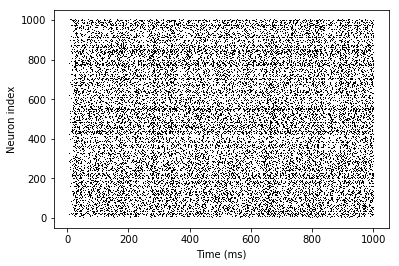

In [265]:
plt.plot(mon_spike_e.t/ms, mon_spike_e.i, ',k')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.show()

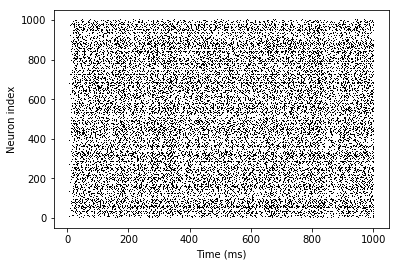

In [266]:
plt.plot(mon_spike_i.t/ms, mon_spike_i.i, ',k')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.show()

In [267]:
Sp_Bin=np.zeros((Ne,np.int(np.max(mon_spike_p.t/ms))+1)).astype(int)

In [268]:
for i in range(Sp_Bin.shape[0]):
    Sp_Bin[i,(mon_spike_e.t[mon_spike_e.i[:]==i]/ms).astype(int)]=1
    
Sp_Bin=Sp_Bin[np.sum(Sp_Bin,axis=1)>0,:]    
    
    

In [270]:
from scipy.stats import pearsonr
Sp_Bin_C=[]
for i in range(Sp_Bin.shape[0]):
    for j in range(i+1,Sp_Bin.shape[0]):
        Sp_Bin_C.append(pearsonr(Sp_Bin[i,],Sp_Bin[j,])[0])

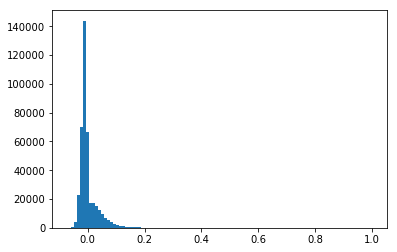

In [271]:
plt.hist(Sp_Bin_C,100);